In [4]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

In [24]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 
from itertools import product

import numpy as np
import scipy.ndimage
import cv2
from multiprocessing import Pool

import sys
sys.path.append('../scripts')
sys.path.append('../nets')
import load_utils
import watereshed
import generator_3D
import unet

from keras.callbacks import ModelCheckpoint
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [6]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}


SIDE = 224
BATCH_SIZE = 32
SPLIT = .15

In [8]:
def load(path, random=True, standardize=True):
    if os.path.basename(os.path.dirname(path)) == 'raw':
        patches = glob(os.path.join(path, 'patch*.npy'))
        patch = np.load(patches[np.random.randint(len(patches))])
        if standardize:

            return np.dstack([
                scipy.ndimage.zoom(patch[..., 0], .7),
                scipy.ndimage.zoom(patch[..., -1], .7, order=0)
            ])
        
        return patch
    
    patch = np.load(os.path.join(path, 'patch.npy'))
    if random:
        return patch[np.random.randint(len(patch))]
    return patch[0]

In [11]:
def preprocess_test(patch):
    window = min(patch.shape[1], int(1.7 * SIDE))
    point = np.array(patch.shape) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape) - window)
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    clip = cv2.resize(patch, dsize=(SIDE, SIDE))
    return clip


def preprocess_val(patch):
    window = min(patch.shape[1], int(1.7 * SIDE))
    point = np.array(patch.shape[:-1]) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])


def preprocess_train(patch):
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    
    if np.random.randint(3):
        shift = np.random.uniform(-.2, .2, size=2)
        shift *= np.array(patch.shape[:2])
        patch = np.dstack([
            scipy.ndimage.shift(patch[..., 0], shift),
            scipy.ndimage.shift(patch[..., -1], shift, order=0)
        ])
        
    if np.random.randint(3):
        rotate = np.random.uniform(-40, 40)
        patch = np.dstack([
            scipy.ndimage.rotate(patch[..., :-1], rotate),
            scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
        ])
    
    scale = np.random.uniform(.5, 1.5)
    window = min(min(patch.shape[:-1]), int(SIDE * scale))
    if np.count_nonzero(patch[..., 1]):
        coords = np.array(np.where(patch[..., 1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.random.randint(0, min(patch.shape[:-1]) - window + 1)
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])

In [13]:
def eval_generator(patient, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_val, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0
        

def test_generator(patient, train_mode=False, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_test, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed, -1) + 199.) / 461.
        

def generator(paths, train_mode=False, batch_size=BATCH_SIZE, shuffle_coef=.7):
    while True:
        paths = [
            os.path.join(
                os.path.dirname(os.path.dirname(path)), 
                os.path.basename(path)
            ) 
            if os.path.basename(os.path.dirname(path)) == 'raw'
            else path
            for path in paths
        ]
        if train_mode:
            np.random.shuffle(paths)
            paths = [
                os.path.join(os.path.dirname(path), 'raw', os.path.basename(path)) 
                if shuffle_coef * len(paths) >= i 
                else path 
                for i, path in enumerate(paths)
            ]
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
            with Pool(4) as pool:
                processed = pool.map(load, batch)

            if train_mode:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_train, processed)
            else:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_val, processed)
            processed = np.array(processed)
            yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0

In [14]:
patient_ids = glob(os.path.join(PATHS['DATA'], 'raw', '*', 'patch_0.npy'))
patient_ids = [os.path.dirname(pid) for pid in patient_ids]
patient_ids = [os.path.join(
                    os.path.dirname(os.path.dirname(pid)), 
                    os.path.basename(pid)
                ) for pid in patient_ids]
patient_ids = [pid for pid in patient_ids if len(os.path.basename(pid)) == 9]

train = patient_ids[int(SPLIT * len(patient_ids)):]
test = patient_ids[:int(SPLIT * len(patient_ids))]

# Train

In [ ]:
model = unet.get_unet(224, 224)

In [ ]:
cval = -0.923
NUM = 300
for i in range(NUM):
    train_gen = generator(train, train_mode=True)

    model.fit_generator(
        train_gen,
        steps_per_epoch= 10 * len(train) // BATCH_SIZE + 1, 
        verbose=1, 
    )

    test_gen = generator(test, train_mode=False)
    valeval = model.evaluate_generator(test_gen, 3)

    print('Iteration %s/%s \n val dice: %s'%(i, NUM, valeval[0]))
    if valeval[0] < cval:
        cval = valeval[0]
        model.save(os.path.join(PATHS['DATA'], 'unet_model'))
        print('-' * 50)

In [ ]:
model.save(os.path.join(PATHS['DATA'], '__unet_model__'))

# Inference

In [ ]:
model = unet.get_unet(224, 224)
model.load_weights(os.path.join(PATHS['DATA'], 'unet_model'))

In [293]:
fd = pd.read_excel('../../DM_Data/REPRISE III Sizes.xlsx')
ctest = [t for t in test if (fd['Subject name or identifier'] == os.path.basename(t)).sum()]


test_idx = 19
patient, meta = load_utils.load_patient(PATHS['DATA'], os.path.basename(ctest[test_idx]), metadata=True)
row = fd[fd['Subject name or identifier'] == os.path.basename(ctest[test_idx])]
print('DIAMETER: ', row['Valve Size (Model number)'])
print(patient.shape)
for key, el in meta.items():
    if key != 'dat':
        print(key, ': ', el)
fact = meta['PixSpac']
patient = scipy.ndimage.zoom(patient, fact, order=3)
print(patient.shape)


test_gen = test_generator(patient)
arr = np.concatenate([next(test_gen) for i in range(len(patient) // BATCH_SIZE + 1)])
test_gen = test_generator(patient)
p = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(patient, 1))
p1 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(patient, 2))
p2 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(np.flip(patient, 1), 2))
p3 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)


pred = np.mean(
    np.stack([
        p, 
        np.flip(p1, 1), 
        np.flip(p2, 2), 
        np.flip(np.flip(p3, 1), 2)
    ], -1), 
    -1
)

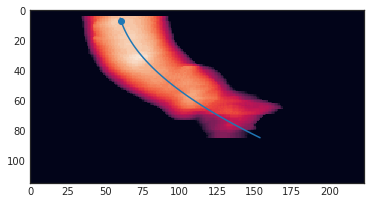

In [294]:
lpred, _ = scipy.ndimage.label(pred[..., 0] > .5)
idx = np.argmax(np.bincount(lpred.flatten())[1:]) + 1
lpred[lpred != idx] = 0
lpred = scipy.ndimage.binary_closing(lpred, iterations=5)
summedx = (lpred).sum(1)

plt.imshow(summedx)

x, y = np.asarray(np.where(lpred))[[0, 2]]
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

point = np.random.choice(np.unique(x))
a = p(point + 1) - p(point)
a = np.tan(np.arctan(a) + np.pi / 2)
w = np.poly1d([a, p(point) - a * point])

xp = np.linspace(x.min(), x.max(), 100)
# xw = np.linspace(point - 50, point + 50, 100)
plt.plot(p(xp), xp, '-');
# plt.plot(w(xw), xw, '-');
plt.scatter(p(point), point)
# plt.axis('off');

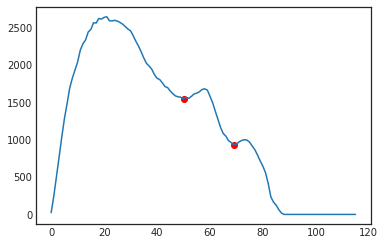

In [304]:
tangs = list()
x_unique = np.unique(x)
# init_p = p
for point in x_unique:
    a = init_p(point + 1) - init_p(point)
    a = np.tan(np.arctan(a) + np.pi / 2)
    w = np.poly1d([a, init_p(point) - a * point])
    
    length = 200
    step = length / ((a ** 2 + 1) ** .5)
    
    xw = np.linspace(point - step // 2, point + step // 2, length)
    #x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
    # Extract the values along the line, using cubic interpolation
    zi = scipy.ndimage.map_coordinates(summedx, np.vstack((xw, w(xw))))
    tangs.append(zi.sum())

tangs = np.array(tangs)
# tangs = scipy.ndimage.gaussian_filter1d(tangs, 4)
args = scipy.signal.argrelextrema(tangs, np.less_equal, order=4, mode='wrap')[0]
args = args[tangs[args] > 10]

plt.plot(x_unique, tangs)
plt.scatter(x_unique[args], tangs[args], c='r')
plt.show()

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


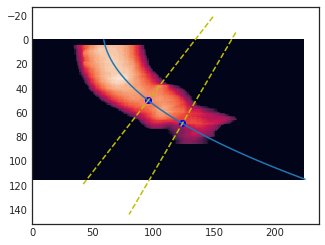

In [305]:
length = min(min(patient.shape[1:]), int(1.7 * SIDE))
shift = np.array(patient.shape[1:]) // 2 - length // 2
shift = np.clip(shift, 0, np.array(patient.shape[1:]) - length)

plt.imshow(summedx)
plt.plot(init_p(xp), xp, '-');
zis = list()

for point in tqdm(x_unique[args].tolist()):
    a = init_p(point + 1) - init_p(point)
    a = np.tan(np.arctan(a) + np.pi / 2)
    w = np.poly1d([a, init_p(point) - a * point])
    
    xp = np.linspace(x.min(), x.max(), 224)
    
    step = length / ((a ** 2 + 1) ** .5)
    xw = np.linspace(point - step // 2, point + step // 2, length)
    
    plt.plot(w(xw), xw, '--', c='y');
    plt.scatter(init_p(point), point, c='b')
    
    coords = np.where(lpred[int(point), int(init_p(point))])[0]
    center = np.median(coords)
    y_axis = np.linspace(center // 2 - length // 2 , center // 2 + length // 2 , length)
    
    
    prod = np.array(list(product(xw, y_axis)))
    prod_y = np.array(list(product(w(xw), y_axis)))
    prod = np.concatenate([prod[:, :1], prod_y], 1)
    prod[:, 1:] += shift
    
    zi = scipy.ndimage.map_coordinates(patient, prod.T)
    zi = zi.reshape((length, length))
    zi = cv2.resize(zi, dsize=(SIDE, SIDE))
    zi = (np.expand_dims(zi, -1) + 199.) / 461.
    
    zis.append(zi)
# plt.axis('off');

In [306]:
zis = list()
for num, point in tqdm(enumerate(x_unique[args])):
    angle = np.arctan(init_p(point) - init_p(point + 1))
    angle *= 180 / np.pi
    angle = np.round(angle)
    rotated, rpoint = rot(summedx, np.array([init_p(point), point]), angle, False)
    mes = scipy.ndimage.interpolation.rotate(lpred[:, :patient.shape[1], :patient.shape[2]], 
                                             angle, (0, 2), order=0, reshape=False)
    pat = scipy.ndimage.interpolation.rotate(patient, angle, (0, 2), reshape=False)

    x, y = np.asarray(np.where(mes))[[0, 1]]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)

    angle = np.arctan(p(x.max()) - p(x.max() + 1))
    angle *= 180 / np.pi
    angle = np.round(angle)
    rotated, rpoint = rot(mes.sum(2), np.array([p(rpoint[1]), rpoint[1]]), angle, reshape=False)
    mes = scipy.ndimage.interpolation.rotate(mes[:, :pat.shape[1], :pat.shape[2]], 
                                             angle, (0, 1), order=0, reshape=False)
    pat = scipy.ndimage.interpolation.rotate(pat, angle, (0, 1), reshape=False)

    i = min(len(pat) - 1, int(rpoint[1]))
    zi = cv2.resize(pat[i], dsize=(SIDE, SIDE))
    zi = (np.expand_dims(zi, -1) + 199.) / 461.
    zis.append(zi)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [307]:
zis = np.stack(zis, 0)
pred = model.predict(zis)

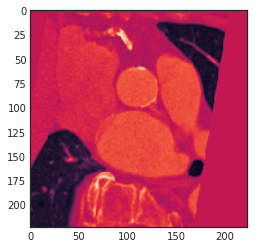

In [299]:
plt.imshow(zis[0][..., 0])
plt.show()

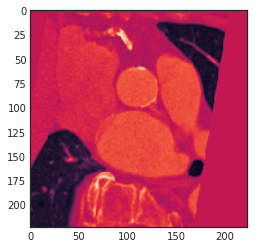

Diameter: 46.9194114717
Diameter convex hull: 47.3381621816


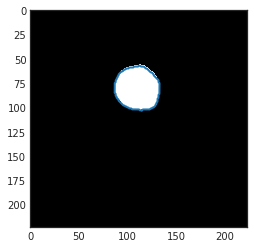

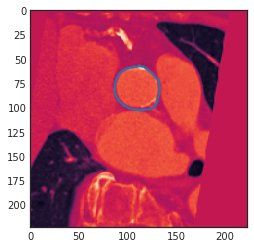

In [308]:
i = 0

plt.imshow(zis[i, ..., 0])
plt.show()

from skimage import measure
from skimage.morphology import convex_hull_image


# Find contours at a constant value of 0.8
mask = pred[i, ..., 0] > .5
mask, _ = scipy.ndimage.label(mask)
idx = np.argmax(np.bincount(mask.flatten())[1:]) + 1
mask = mask == idx
cmask = convex_hull_image(mask)
print('Diameter:', 2 * np.sqrt(mask.sum() / np.pi))
print('Diameter convex hull:', 2 * np.sqrt(cmask.sum() / np.pi))
contours = measure.find_contours(mask, .9)

# Display the image and plot all contours found


fig, ax = plt.subplots()
ax.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

plt.imshow(zis[i, ..., 0])
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

# Hard negative mining

In [ ]:
model = unet.get_unet(224, 224)
model.load_weights(os.path.join(PATHS['DATA'], 'unet_model'))

In [56]:
def np_dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )

In [ ]:
for t in tqdm(train):
    patient, meta = load_utils.load_patient(PATHS['DATA'], os.path.basename(t), metadata=True)
    meshs = glob(os.path.join(PATHS['DATA'], os.path.basename(t), '*_A.stl'))
    meshs = load_utils.load_mesh(meshs[0], meta) 
    meshs = meshs[:patient.shape[0], :patient.shape[1], :patient.shape[2]]
    patient = np.stack([patient, meshs], -1)
    test_gen = eval_generator(patient, batch_size=len(patient))
    cgen = next(test_gen)
    valeval = model.predict(cgen[0], 32)
    valeval = np.array([np_dice_coef(cgen[1][i], valeval[i]) for i in range(len(valeval))])
    np.save(os.path.join(t, 'dice'), valeval)
    print(os.path.join(t, 'dice'))
    break